In [45]:
#pip install opencv-python -q
#pip install pandas
#pip install numpy
#pip install matplotlib
#pip install tqdm
#pip install torch
#pip install torchvision
#pip install torchsummary 
#pip install seaborn
#pip install  sklearn
#pip install albumentations
#pip install PIL
#pip install Warning
#pip install Image
#pip install fastapi



In [45]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from time import time
from tqdm import tqdm
# from pycocotools.coco import COCO
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import cv2
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
from torchvision.transforms import v2
import torchvision.transforms.functional as functional
from torchsummary import summary
from torchvision.utils import save_image

from matplotlib import pyplot as plt
from torchvision.io import read_image, ImageReadMode

from torchvision.models import resnet50, ResNet50_Weights # , densenet121, DenseNet121_Weights
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import (roc_auc_score, f1_score)
from sklearn.metrics import roc_curve # , auc
import albumentations as A
import logging

In [9]:
 device = (
     "cuda"
     if torch.cuda.is_available()
     else "mps"
     if torch.backends.mps.is_available()
     else "cpu"
     )
print(f"Using {device} device")

Using mps device


In [11]:
 data_path = '/Users/pozdnyakov/Desktop/ds/'
 out_path = '/Users/pozdnyakov/Desktop/ds/result/'
 folders = ['0', '90', '180', '270']
CLASSES = {'0': 0,
           '90': 1,
           '180': 2,
           '270':3
}

In [77]:
 def rotateImages(rotationAmt):
    folder_0 = os.path.join(data_path, folders[0])
    for image in os.listdir(folder_0):
        img = Image.open(os.path.join(folder_0, image))
        temp_rot_image = img.rotate(rotationAmt, expand=True)
        new_image_folder = os.path.join(data_path, f'{rotationAmt}')
        trunk, ext = os.path.splitext(image)
        new_image_name = f'{trunk}_{rotationAmt}{ext}'
        temp_rot_image.save(os.path.join(new_image_folder, new_image_name))
        img.close()

In [79]:
rotateImages(90)
rotateImages(180)
rotateImages(270)

In [12]:
BATCH_SIZE = 36
IMG_SIZE = 255
IMG_SIZE_D = 320
generator = torch.Generator().manual_seed(42)

In [14]:
transformer = v2.Compose([
    v2.Pad(padding=10, fill=0, padding_mode='constant'),
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale=True),
    v2.Resize(255),
    v2.CenterCrop((IMG_SIZE,IMG_SIZE))
    #v2.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5))
     ])

In [16]:
class DonorSearchData(torch.utils.data.Dataset):
     def __init__(self, root, label, transform):
         self.root = root
         self.label = label
         self.transforms = transform
         self.imgs = os.listdir(os.path.join(self.root, self.label))

     def __getitem__(self, idx):
         # load images and labels
         img_path = os.path.join(self.root, self.label, self.imgs[idx])
         img = Image.open(img_path).convert('RGB')
         target = CLASSES[self.label]

         return self.transforms(img), torch.tensor(target), self.label

     def __len__(self):
         return len(self.imgs)

In [17]:
data_1 = DonorSearchData(data_path, folders[0], transformer)
data_2 = DonorSearchData(data_path, folders[1], transformer)
data_3 = DonorSearchData(data_path, folders[2], transformer)
data_4 = DonorSearchData(data_path, folders[3], transformer)
print(f'classes size: \n {folders[0]} -- {len(data_1)} \n {folders[1]} -- {len(data_2)} \n {folders[2]} -- {len(data_3)} \n {folders[3]} -- {len(data_4)} \n')
data_new = ConcatDataset([data_1, data_2, data_3, data_4])
train, valid, test = torch.utils.data.random_split(data_new , [.6, .2, .2], generator=generator)
print(f"train - {len(train)} \n valid - {len(valid)} \n test - {len(test)}")

classes size: 
 0 -- 72 
 90 -- 72 
 180 -- 72 
 270 -- 72 

train - 173 
 valid - 58 
 test - 57


In [18]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE,shuffle=False,num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE,shuffle=False,num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


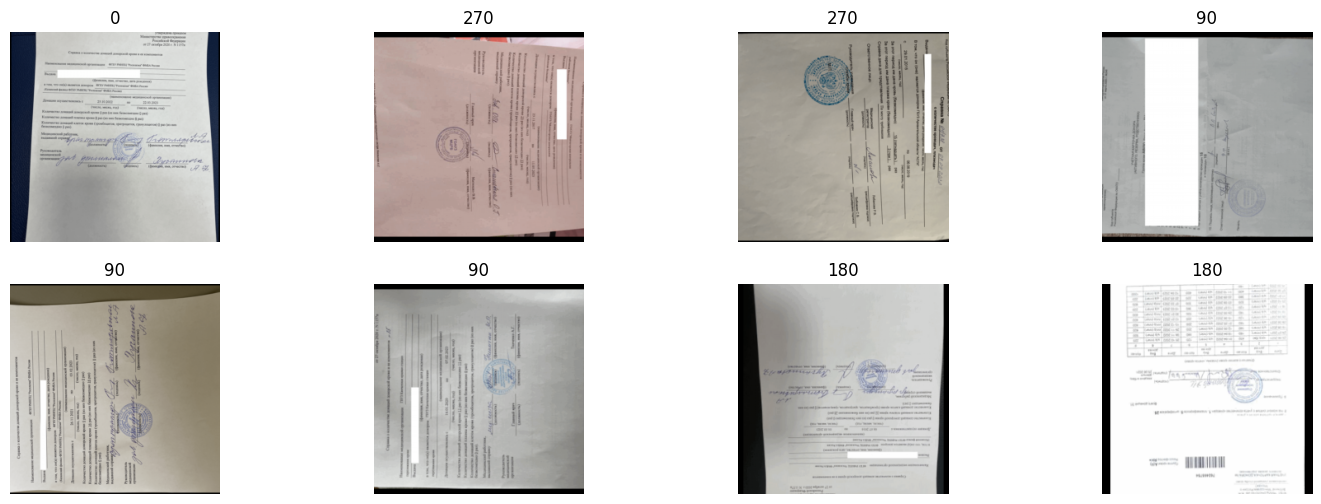

In [19]:
look = next(iter(train_dataloader))
plt.figure(figsize=(18, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    plt.title(look[2
                  ][i])
plt.show();

In [20]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels, _ in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [21]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels, _ in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [22]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [23]:
def train(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train, criterion, opt, sch)

            val_loss, val_acc = eval_epoch(model, val, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [24]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model)
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(model)
    plt.show()

In [25]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Set requires_grad = False for all parameters
for param in resnet.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(resnet.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 4
resnet.fc = nn.Linear(in_features, out_features)
resnet = resnet.to(device)
# summary(resnet, (3,IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

In [26]:
out = resnet(torch.rand(64, 3, 224, 224).to(device))
out[0]

tensor([ 0.1760,  0.0833, -0.0267, -0.0730], device='mps:0',
       grad_fn=<SelectBackward0>)

In [27]:
ce = nn.CrossEntropyLoss()
lr = 3e-4
history = train(train_dataloader, valid_dataloader, model=resnet, epochs=6, rate=lr, criterion=ce)

epoch:  17%|█▋        | 1/6 [00:13<01:07, 13.44s/it]


Epoch 001 train_loss: 1.2862     val_loss 1.2611 train_acc 0.4220 val_acc 0.4483


epoch:  33%|███▎      | 2/6 [00:23<00:45, 11.28s/it]


Epoch 002 train_loss: 0.5179     val_loss 0.7565 train_acc 1.0000 val_acc 0.7241


epoch:  50%|█████     | 3/6 [00:32<00:31, 10.43s/it]


Epoch 003 train_loss: 0.1381     val_loss 0.3899 train_acc 1.0000 val_acc 0.7759


epoch:  67%|██████▋   | 4/6 [00:42<00:20, 10.11s/it]


Epoch 004 train_loss: 0.0245     val_loss 0.3469 train_acc 1.0000 val_acc 0.8276


epoch:  83%|████████▎ | 5/6 [00:51<00:09,  9.75s/it]


Epoch 005 train_loss: 0.0050     val_loss 0.3261 train_acc 1.0000 val_acc 0.8621


epoch: 100%|██████████| 6/6 [00:59<00:00, 10.00s/it]


Epoch 006 train_loss: 0.0021     val_loss 0.2464 train_acc 1.0000 val_acc 0.8966


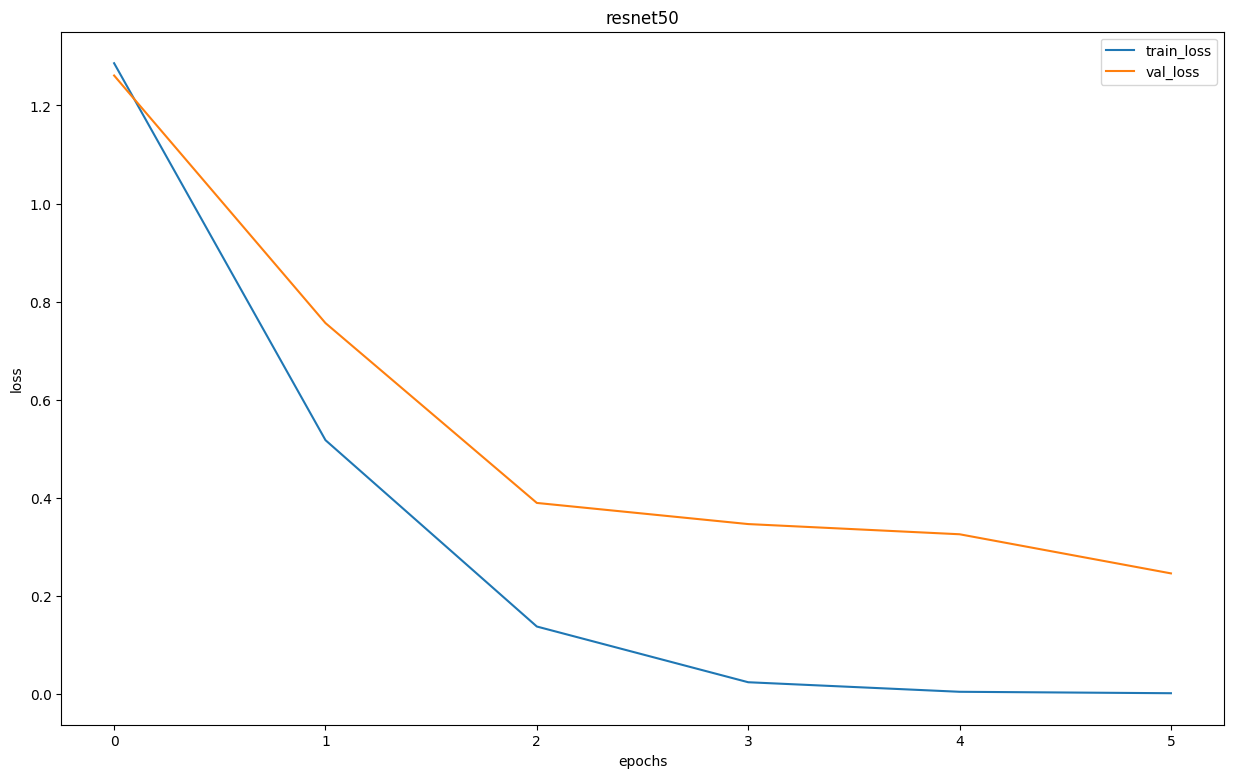

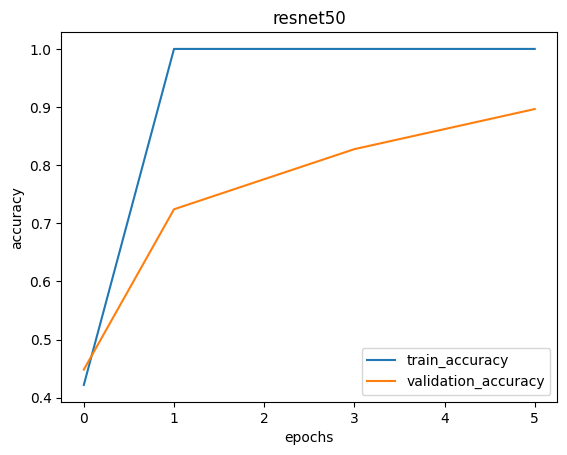

In [28]:
vizualize(history, 'resnet50')

In [29]:
result_1 = predict(resnet, test_dataloader)
print(f'Test Accuracy for resnet50 -- {result_1[3]:.2}')

Test Accuracy for resnet50 -- 0.89


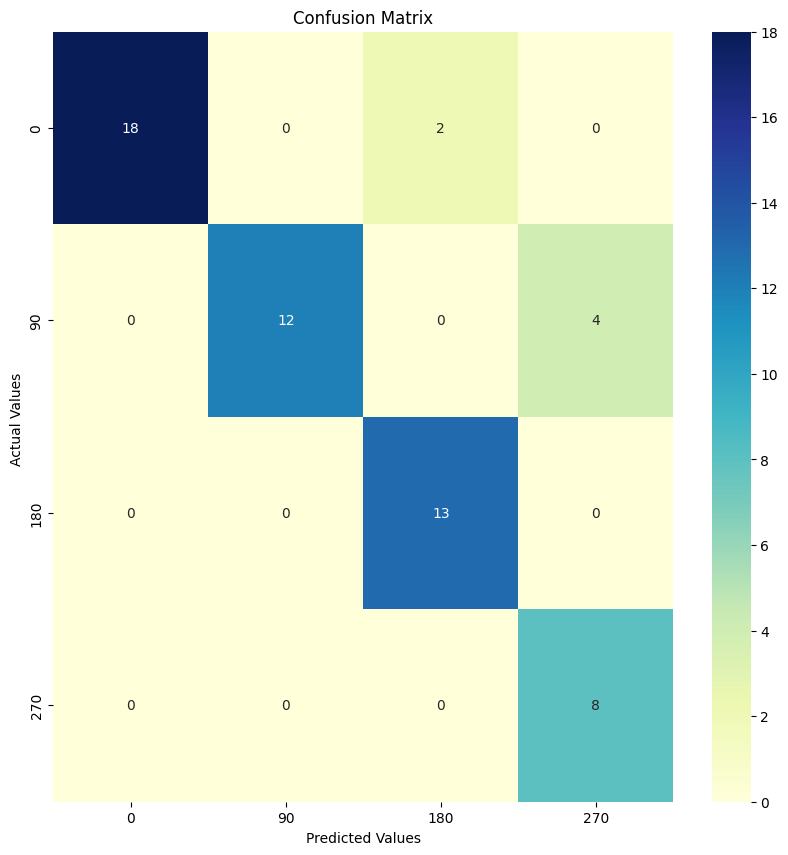

In [30]:
result = result_1
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','90', '180', '270'])
ax.yaxis.set_ticklabels(['0','90', '180', '270'])
plt.show()

In [100]:
torch.save(resnet.state_dict(), os.path.join(data_path, 'resnet_trained.pth'))

In [31]:
pretrained_weights = torch.load(os.path.join(data_path, 'resnet_trained.pth'), map_location=torch.device('mps'))

In [32]:
model_trained = resnet50(pretrained=False)

# Set requires_grad = False for all parameters
for param in model_trained.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(model_trained.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 4
model_trained.fc = nn.Linear(in_features, out_features)
model_trained.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [33]:
model_trained.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
def predict_rotate(img_path):
  # загружаем одну картинку
  img=Image.open(img_path).convert('RGB')
  # трансформируем
  input = transformer(img)
  # предсказываем ориентацию картинки моделью
  output = model_trained(input.unsqueeze(0))
  prediction = int(torch.max(output.cpu().data, 1)[1].numpy())
  if prediction != 0:
    classes_list = list(CLASSES.keys())
    # вычисляем угол поворота
    rotation_angle = 360 - int(classes_list[prediction])
    # поворачиваем изображение
    rot_img = img.rotate(rotation_angle, expand=True)
    # save the image with new filename into folder
    img_name = img_path.split('/')[-1]
    trunk, ext = os.path.splitext(img_name)
    new_img_name = f'{trunk}_rotated_{classes_list[prediction]}{ext}'
    rot_img.save(os.path.join(out_path, new_img_name))
    # close the image
    img.close()
  else:
    img_name = img_path.split('/')[-1]
    trunk, ext = os.path.splitext(img_name)
    new_img_name = f'{trunk}_not_rotated{ext}'
    img.save(os.path.join(out_path, new_img_name))
    # close the image
    img.close()
  return  prediction

In [43]:
predict_rotate('/Users/pozdnyakov/Desktop/ds/180/405___2601bf92cd624eb6ac16ed3637c67f57_180.png')

2